<a href="https://colab.research.google.com/github/lopesmatheus/COA19-PythonSimu/blob/main/Main_PIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIE - DDPG Continuous

## Prerequisites

In [2]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [1]:
!pip install pytorch

  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch: started
    Running setup.py install for pytorch: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\mathe\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\mathe\\AppData\\Local\\Temp\\pip-install-rktah3ko\\pytorch_bf3c788ab9694a029e54a3e0c7610990\\setup.py'"'"'; __file__='"'"'C:\\Users\\mathe\\AppData\\Local\\Temp\\pip-install-rktah3ko\\pytorch_bf3c788ab9694a029e54a3e0c7610990\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\mathe\AppData\Local\Temp\pip-wheel-sphozsbe'
       cwd: C:\Users\mathe\AppData\Local\Temp\pip-install-rktah3ko\pytorch_bf3c788ab9694a029e54a3e0c7610990\
  Complete output (5 lines):
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\mathe\AppData\Loca

In [3]:
import gym
import numpy as np
import time

### Environnement Plant

In [2]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from A_T01a import A_T01a
import numpy as np
import shutil
import pandas as pd

In [ ]:
# define the model name and simulation parameters

class PlantEnv:
    def __init__(self,CaseTest,Hysteresis,step_size):
        
        self.Hysteresis = Hysteresis
        
        self.CaseTest = CaseTest
        
        fmu_plant_filename = 'PLANT_v3.fmu'
        self.step_size = step_size
        
        self.Tend = self.CaseTest.getTsimu() - self.CaseTest.getTend()

        # read the model description
        plant_description = read_model_description(fmu_plant_filename)

        # collect the value references
        self.plant_vrs = {}
        for variable in plant_description.modelVariables:
            self.plant_vrs[variable.name] = variable.valueReference

        self.inputs_plant = [v for v in plant_description.modelVariables if v.causality == 'input']
        self.outputs_plant = [v for v in plant_description.modelVariables if v.causality == 'output']

        input_plant_order = []
        
        for v in self.inputs_plant:
            input_plant_order.append(v.valueReference)

        self.CaseTest.setInputOrder(input_plant_order)

        # extract the FMU
        self.unzipdir_plant = extract(fmu_plant_filename)

        self.fmu_plant = FMU2Slave(guid=plant_description.guid,
                             unzipDirectory=self.unzipdir_plant,
                             modelIdentifier=plant_description.coSimulation.modelIdentifier,
                             instanceName='instance1')

        # initialize
        self.fmu_plant.instantiate()
        self.fmu_plant.setupExperiment(startTime=0)
        self.fmu_plant.enterInitializationMode()
        self.fmu_plant.exitInitializationMode()
        
        self.fmu_plant.setReal([self.inputs_plant[1].valueReference], [self.Hysteresis])       # HYSTERESIS 
        
        for cst in self.CaseTest.getConstantsInputs():
            vr = self.inputs_plant[cst].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,0)])
            
        self.counter = 0
        self.time = 0
        
    def reset(self):
        self.fmu_plant.reset()
        self.fmu_plant.setupExperiment(startTime=0)
        self.fmu_plant.enterInitializationMode()
        self.fmu_plant.exitInitializationMode()
        
        self.fmu_plant.setReal([self.inputs_plant[1].valueReference], [self.Hysteresis])       # HYSTERESIS 
        
        for cst in self.CaseTest.getConstantsInputs():
            vr = self.inputs_plant[cst].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,0)])
            
        self.counter = 0
        self.time = 0
        
    def step(self, action):
        for var in self.CaseTest.getVariablesInputs():
            vr = self.inputs_plant[var].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,self.counter)])
            
        self.fmu_plant.setReal([self.inputs_plant[0].valueReference], [action])
        
        self.fmu_plant.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
        
        self.counter += 1
        self.time += self.step_size
        
        if self.time < self.Tend:
            done = False
        else:
            done = True
        
        TBAS_SENSOR = self.fmu_plant.getReal([self.outputs_plant[4].valueReference])[0]
        FAV_POSITION_DEG = self.fmu_plant.getReal([self.outputs_plant[0].valueReference])[0]
        
        T_target = self.CaseTest.getT_tgt_C()
        
        error = abs(TBAS_SENSOR - T_target[0])
        
        reward = - error**2 - 100 * max(self.time-60,0) * max(error-10,0) - 100 * max(self.time-120,0) * max(error-5,0)    
            
        return TBAS_SENSOR, reward, done, _
    
    def kill_plant(self):
        self.fmu_plant.terminate()
        self.fmu_plant.freeInstance()

        # clean up
        shutil.rmtree(self.unzipdir_plant, ignore_errors=True)

### Agent

To simplify the global code of this notebook, we will use a mother class for each of our agents. This will allow us to build a simulation function that take in argument an environment and an agent, and work with any agents and any environments. Then all you will have to do is to describe what the agent should do at each step of the learning.

In [4]:
import random
import torch
from torch import nn
from statistics import mean
import matplotlib.pyplot as plt
import copy

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
class ReplayBuffer:
    def __init__(self, capacity, device=DEVICE):
        self.capacity = capacity # capacity of the buffer
        self.device = device
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(x).to(self.device), list(zip(*batch))))

    def __len__(self):
        return len(self.data)

class Agent:
    """
    An global agent class that describe the interactions between our agent and it's environment
    """
    def __init__(self, state_space, action_space, device=DEVICE, name="base_agent"):

        self.name = name  # The name is used inside plot legend, outputs directory path, and outputs file names

        self.state_space = state_space
        self.state_shape = state_space.shape
        self.state_size = state_space.shape[0]  # Assume state space is continuous

        self.continuous = isinstance(action_space, gym.spaces.Box)
        self.action_space = action_space
        self.nb_actions = self.action_space.shape[0] if self.continuous else self.action_space.n
        print(self.nb_actions)
        self.last_state = None  # Useful to store interaction when we recieve (new_stare, reward, done) tuple
        self.device = device
        self.episode_id = 0
        self.episode_time_step_id = 0
        self.time_step_id = 0
    
    def on_simulation_start(self):
        """
        Called when an episode is started. will be used by child class.
        """
        pass
    
    def on_episode_start(self, state):
        self.last_state = state
        self.episode_time_step_id = 0
        self.episode_id = 0

    def action(self, state):
        res = self.action_space.sample()
        return res

    def on_action_stop(self, action, new_state, reward, done):
        self.episode_time_step_id += 1
        self.time_step_id += 1
        self.last_state = new_state

    def on_episode_stop(self):
        self.episode_id += 1

    def on_simulation_stop(self):
        pass


cuda


Now let's build a function that run a simulation where a given agent interact with a givent environment. 

## Actor-critic

<div id="actor_critic"></div>
To understand in detail how it work, we are going to implement two of the most known off-policy actor critic architectures, Deep-Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC). 

### Deep-Deterministic Policy Gradient (DDPG)

<div id="ddpg"></div>

DDPG is considered as an off-policy algorithm, because the policy used to train the critic is different than the one used to generate samples.

For the general idea, when we select an interaction (s, a, r, s', a') to train our critic network, the way a' will be chosen will define the reward propagation (generally called credit assignment) speed. If a' is the optimal action from s', like in DQN, there is a high probability to get an action that lead in interestig and highly valuated states s''. In that case, the high values and the rewards will be propagated to (s, a) value, more frequently than s'' with low value.

If you didn't got it, you can also check this course from Olivier SIGAUD on youtube : https://youtu.be/hlhzvQnXdAA

Note that the default DDPG algorithm don't use epsilon-greedy, but add a noise on the action to make it explore. The original paper use a OU-noise, but for simplicity, we will generate a gaussian noise N(mean, std) to noise our action.


In [5]:
from torch import optim

def init_weights(layer, bound=None):
    if bound is None:
        bound = 1. / np.sqrt(layer.weight.data.size()[0])
    torch.nn.init.uniform_(layer.weight.data, -bound, bound)
    torch.nn.init.uniform_(layer.bias.data, -bound, bound)


class DefaultNN(nn.Module):
    def __init__(self, learning_rate, input_dims, layer_1_dims, layer_2_dims, output_dims, device,
                 last_activation=None):
        super().__init__()
        self.last_activation = last_activation
        self.layer_1 = nn.Linear(input_dims, layer_1_dims)
        init_weights(self.layer_1)
        self.layer_norm_1 = nn.LayerNorm(layer_1_dims)

        self.layer_2 = nn.Linear(layer_1_dims, layer_2_dims)
        init_weights(self.layer_2)
        self.layer_norm_2 = nn.LayerNorm(layer_2_dims)

        self.layer_3 = nn.Linear(layer_2_dims, output_dims)
        init_weights(self.layer_3, bound=0.003)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.device = device
        self.to(self.device)

    def forward(self, inputs):
        running_output = self.layer_1(inputs)
        running_output = self.layer_norm_1(running_output)
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_2(running_output)
        running_output = self.layer_norm_2(running_output)
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_3(running_output)

        if self.last_activation is not None:
            running_output = self.last_activation(running_output)
        return running_output

    def converge_to(self, other_model, tau=0.01):
        """
        Make the value of parameters of this model converge to one from the given model.
        The parameter tau indicate how close our weights should be from the one of the other model.
        self.converge_to(other_model, tau=1) is equivalent to self = copy.deepcopy(other_model).

        other_model should have the same shape, dimensions, than self.
        """
        for self_param, other_param in zip(self.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

In [25]:
import numpy as np
from scipy.integrate import odeint

class CarPend:
    def __init__(self,max_time=700):
        self.M = 400/1000
        self.m = 50/1000
        self.action_space = gym.spaces.Box(-5.0,5.0,(1,),np.float64)
        self.observation_space=gym.spaces.Box(np.array([-5.0,-10.0,-2.0*np.pi,-10.0]),np.array([5.0,10.0,2.0*np.pi,10.0]),(4,),np.float64)
        self.dt = 0.01
        self.count=0
        self.L = 0.3
        
        self.x = 0
        self.xp = 0
        self.xpp = 0
        
        self.theta = 0
        self.thetap = 0
        self.thetapp = 0
        self.max_time=max_time
        
    def reset(self):
        self.x = 0
        self.xp = 0
        self.count=0
        self.theta = np.random.uniform(-np.pi/100., np.pi/100.)
        self.thetap = 0#np.random.uniform(-0.1,0.1)

        state = [self.x,self.xp,self.theta,self.thetap]
        return np.array(state)

    def dynamic_mod(self,x0,t,f):
        x1,x2,x3,x4 = x0
        tol = 10**(-6)
        er = 1
        g = 9.81
        b = 0.01
        
        dx2dt_old = self.xpp
        dx4dt_old = self.thetapp
        
        while er>tol:
            if abs(x1)>=5:
                dx2dt = 0
            else:
                dx2dt = (f - dx4dt_old * self.m * self.L * np.cos(x3) + self.m * self.L * (x4**2) * np.sin(x3)) / (self.M + self.m)
            
            dx4dt = (self.m * g * self.L * np.sin(x3) - self.m * self.L * np.cos(x3) * dx2dt - b*x4) / (self.m * self.L**2)
            
            er = max(abs(dx2dt - dx2dt_old),abs(dx4dt - dx4dt_old))
            
            dx2dt_old = dx2dt
            dx4dt_old = dx4dt
        
        self.xpp = dx2dt
        self.thetapp = dx4dt
        return np.array([float(x2),float(dx2dt),float(x4),float(dx4dt)])
    
    def step(self,action):
        done=False
        self.count+=1
        x0 = np.array([self.x,self.xp,self.theta,self.thetap])
        t=np.array([0,self.dt])
        self.action=action
        
        #print(self.action.dtype)
        sol = odeint(self.dynamic_mod,x0,t,args=(self.action,))
        
        self.x = sol[-1,0]
        self.x = max(self.x,-5)
        self.x = min(self.x, 5)
        
        if abs(self.x)>=5:
            self.xp = 0
        else:
            self.xp = sol[-1,1]
        
        self.theta = sol[-1,2]
        self.thetap = sol[-1,3]
        
        state = [self.x,self.xp,self.theta,self.thetap]
        
        if abs(self.x)<=2.5 and abs(self.theta)<=50*np.pi/180:
            done = False
            reward = 1
            
        else:
            done = True
            reward = 0

        #reward=-np.exp(self.theta**2)
        
        if self.count>=self.max_time:
          done=True
            
        return np.array(state), reward, done,_

In [7]:
def simulation(environment, agent, nb_episodes=200, verbose=True):
    episodes_rewards_sum = []
    agent.on_simulation_start()
    for episode_id in range(nb_episodes):
        state = environment.reset()
        agent.on_episode_start(state)

        episode_rewards = []
        done = False
        while not done:
            action = agent.action(state)
            state, reward, done ,_= environment.step(action)
            # Ending time step process ...
            agent.on_action_stop(action, state, reward, done)

            # Store reward
            episode_rewards.append(reward)
        agent.on_episode_stop()
        rewards_sum = sum(episode_rewards)
        episodes_rewards_sum.append(rewards_sum)
        #environment.close()
        if len(episodes_rewards_sum) > 20:
            last_20_average = mean(episodes_rewards_sum[-20:])
        else:
            last_20_average = mean(episodes_rewards_sum)

        if verbose:
            print("Episode ", '{:3d}'.format(episode_id),
                  ", episode return ", '{:4.1f}'.format(rewards_sum),
                  ", last 20 avg ", '{:4.1f}'.format(last_20_average),
                  sep='')
    return episodes_rewards_sum

In [9]:
# %load solutions/RL6_DDPG.py
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

### NEW indicate the differences between DQN and DDPG.
class DDPGAgent(Agent):
    def __init__(self, state_space, action_space, device, actor_lr=0.000025, critic_lr=0.00025, tau=0.001, gamma=0.99,
                 max_size=100000, layer1_size=200, layer2_size=150, batch_size=64, noise_std=0.1, name="DDPG"):
        assert isinstance(action_space, gym.spaces.Box)  ### NEW: The action space is now continuous 
        super().__init__(state_space, action_space, device=device, name=name)
        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(max_size, self.device)
        self.batch_size = batch_size

        self.actor = DefaultNN(actor_lr, self.state_size, layer1_size, layer2_size, self.nb_actions
                               , self.device,
                               last_activation=None)
        self.critic = DefaultNN(critic_lr, self.state_size + self.nb_actions, layer1_size, layer2_size, 1, self.device)

        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)

        self.normal_distribution = torch.distributions.normal.Normal(
            torch.zeros(self.nb_actions), torch.full((self.nb_actions,), noise_std))

    def action(self, observation):
        with torch.no_grad():
            observation = torch.tensor(observation, dtype=torch.float).to(self.device)
            actor_output = self.actor.forward(observation).to(self.device)
            #action=torch.normal(actor_output[0], np.abs(actor_output[1]))
            noise = self.normal_distribution.sample().to(self.device)
            action = actor_output + noise
        return action.cpu().detach().numpy()

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)

    def learn(self):
        #if len(self.replay_buffer) > self.batch_size:
        if len(self.replay_buffer.data) > self.batch_size:
            states, actions, rewards, new_states, dones = self.replay_buffer.sample(self.batch_size)

            with torch.no_grad():
                target_actions = self.target_actor.forward(new_states)
                critic_value_ = self.target_critic.forward(torch.concat((new_states, target_actions), dim=-1))
            critic_value = self.critic.forward(torch.concat((states, actions), dim=-1))
            target = torch.addcmul(rewards, self.gamma, 1 - dones, critic_value_.squeeze()).view(self.batch_size, 1)
            self.critic.optimizer.zero_grad()
            critic_loss = torch.nn.functional.mse_loss(target, critic_value)
            critic_loss.backward()
            self.critic.optimizer.step()

            self.actor.optimizer.zero_grad()
            actions = self.actor.forward(states)
            actor_loss = - self.critic.forward(torch.concat((states, actions), dim=-1))
            actor_loss = torch.mean(actor_loss)
            actor_loss.backward()
            self.actor.optimizer.step()

            self.target_critic.converge_to(self.critic, tau=self.tau)
            self.target_actor.converge_to(self.actor, tau=self.tau)

# Test our agent on Pendulum-v0
#environment = gym.make('Pendulum-v1')
environment = CarPend()
agent = DDPGAgent(environment.observation_space, environment.action_space, device=DEVICE)
simulation(environment, agent,nb_episodes=5000)


1


<ipython-input-9-5f8704b773eb>:49: UserWarning: This overload of addcmul is deprecated:
	addcmul(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcmul(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  target = torch.addcmul(rewards, self.gamma, 1 - dones, critic_value_.squeeze()).view(self.batch_size, 1)


Episode   0, episode return 88.0, last 20 avg 88.0
Episode   1, episode return 138.0, last 20 avg 113.0
Episode   2, episode return 80.0, last 20 avg 102.0


KeyboardInterrupt: ignored

In [ ]:

torch.save(agent.actor.state_dict(), 'act_checkpoint.pth')
#agent.critic.save('act_checkpoint.pth')
torch.save(agent.critic.state_dict(), 'crit_checkpoint.pth')

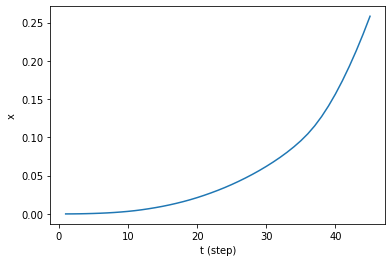

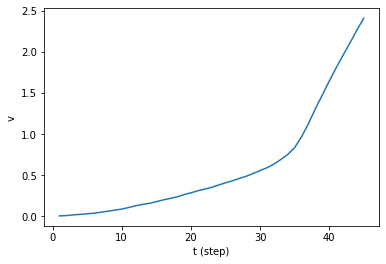

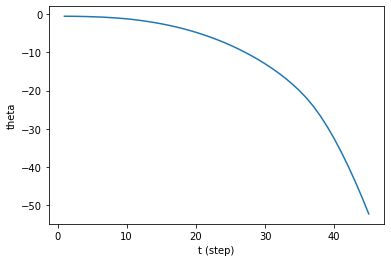

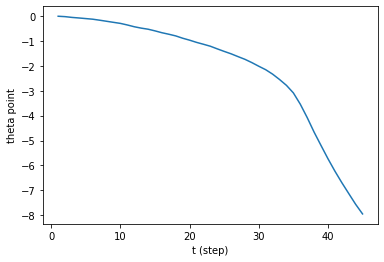

In [46]:
# There. we finished
# Lets see it in action
cartpole=CarPend()
done = False
cnt = 0
observation = cartpole.reset()
t=[]
x=[]
xp=[]
th=[]
thp=[]
while not done :
    cnt += 1
    t.append(cnt)

    action = agent.action(observation)
    observation, reward, done,_ = cartpole.step(action)
    x.append(observation[0])
    xp.append(observation[1])
    th.append(observation[2])
    thp.append(observation[3])



    # Lets see how long it lasts until failing


plt.figure()
plt.plot(t,x)
plt.xlabel('t (step)')
plt.ylabel('x')

plt.figure()
plt.plot(t,xp)
plt.xlabel('t (step)')
plt.ylabel('v')

plt.figure()
plt.plot(t,np.array(th)*180/np.pi)
plt.xlabel('t (step)')
plt.ylabel('theta')

plt.figure()
plt.plot(t,thp)
plt.xlabel('t (step)')
plt.ylabel('theta point')
#plt.figure()
#plt.plot(t,xpp)

plt.show()

### Soft Actor-critic (SAC)

<div id="sac"></div>

Soft Actor-Critic is really close to DDPG, except that it learn using a regularised entropy on actions policy.

#### Shanon entropy

Let X be a random variable with a law of density p(X) satisfying the normalization and positivity requirements, we define its entropy by
$$-\int_{X} p(x) log (p(x))$$

It allows to quantify the disorder of a random variable. The entropy is maximal when X follows an uniform distribution, and minimal when p(X) is equal to zero everywhere except in one value, which is a Dirac distribution.

#### Why entropy in SAC?

In SAC algorithm, we not only consider the critic evaluation inside the actor loss, but also it's decision entropy.
The loss of the agent should be high when the entropy is low, because it will invite him to explore more.
The mode the entropy of the agent is important, the more it will explore.

More, SAC use entropy to estimate next_states value. The more the entropy of the target actor is important while choosing a', the more s' will be condidered as highly valuable.
To illustrate the intiution behing this, let's imagine an environment with a discrete state space, in a sigle line: 


|    |    |    |
|:--:|:--:|:--:|
| +1 | A  | +1 |

In the exemple above, the agent (A) will recieve a reward of +1 at the next round, whatever the next action he will chose. Because the actor loss make him maximise critig grade and entropy, he will improve entropy when the critig grage cannot be improved anymore. In this case, the critic value will everytime be the same, whatever the action taken by the agent. For this reason, the action entropy will be maximize, so the agent will have the same probability to go in any directions.

This fact bring a side effect. Because states are consider good when the entropy of the action taken from them is high, the agent will maintain itself in states where he will be sake whatever the next taken action. This behavior is also present in DDPG but is strengten here but the entropy maximisation, making our agent gain in stability (you will observe the gap in performances standard deviation latter).


|    |    |    |
|:--:|:--:|:--:|
| -1 | A  | +1 |

In this new case, the entropy of the action will be low because the actor loss will be lower if the critic evaluation is high, so he should choose deterministic action that leads to states with the higher value.

In other words, we can say that SAC will perform a better exploration/exploitation trade-off, by takin both the advantage of a high exploration, and the advantage of a high exploitation. He will maximize exploration by mawimising entropy, but will not suffer from the incovenient of high exploration that is fall in bad state and never enstrenght the optimal trajectory the the best rewards, because he will fly away from bad rewarding states.


#### How to use entropy in SAC?

To compute an entropy, we need the actor to give use a random distribution. The most common way to archieve that, is to make the actor with 2 * nb_action outputs neurons, giving actions means and standard deviations.

Because the standart deviation, it is common to make the actor return the log(std), and then get the real std with $e^{log_std}$. But we can also put the std output inside a relu().

To get the action, we can sample actions from the means and standard deviations we got. Doing this will prevent us latter to retro-propagate the gradient when we will train our actor, so we should do a reparametrization trick when we want to compute actions for actor training (more explanation in the code to fill bellow).
Sample with reparametrisation is equivalent to compute $a = \mu + \mathcal{N}(0,\,1)\ * sigma$.

In general, for a given a', we maximise entropy my minimising $log (p(x))$. Looking at the entropy function, we can understand that $log(p(x))$ have a higher impact than p(x) only, because p(x) is between 0 and 1, and $|log(p(x))|$ is generally extremly high because p(x) is generally close to 0.

Because our environment action space is bounded, but our normal distribution is not, we can put the actions we got inside tanh function to get some between -1 and 1, and then scale it to our environment action space. Because we bould our actions, we should do a process over our log prob as follow:

        log_probs = actions_distribution.log_prob(actions)
        log_probs -= torch.log(1 - action.pow(2) + self.min_std)
        log_probs = log_probs.sum(dim=-1)
        
We are not going deeper about these mathematicals details, but if you are interested, the explanation if this is in [SAC paper](https://arxiv.org/pdf/1812.05905.pdf), appendic C (bottom of page 16).

Now you should have any informations to complete the code bellow for SAC implementation! To gain some time, wome code parts are already filled.

NB: Algorithm hyperparameters are given in $__init__$ function, the new alpha hyper parameter is the ratio between Q value and entropy inside critic update:
$$V(s') = TargetCritic(s', a') - alpha * LogProb$$ where $$a', LogProg = SampleAction(s')$$

Note that SAC is very stable and converge well, so you don't neet to have low learning rate and you also can use a Sequential() model (like we did with DQN) without LayerNorm layers inside.

In [26]:

from torch import optim
import torch.nn.functional as f
from torch.distributions.normal import Normal

class SACAgent(Agent):
    def __init__(self, state_space, action_space, device, actor_lr=0.01, critic_lr=0.01, gamma=0.98,
                 max_size=1000000, tau=0.005, layer1_size=128, layer2_size=128, batch_size=128, alpha=1):
        super().__init__(state_space, action_space, device, "SAC")
        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(max_size, self.device)
        self.batch_size = batch_size
        self.state_size = state_space.shape[0] 
        self.actions_bounds_range = torch.tensor((action_space.high[0] - action_space.low[0]) / 2).to(self.device)
        self.actions_bounds_mean = torch.tensor(mean((action_space.high[0], action_space.low[0]))).to(self.device)
        self.min_std = 1

        self.actor = nn.Sequential(nn.Linear(self.state_size, layer1_size), nn.Tanh(),
                                   nn.Linear(layer1_size, layer2_size), nn.Tanh(),
                                   nn.Linear(layer2_size, 2 * self.nb_actions)).to(device=self.device).float()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.target_actor = copy.deepcopy(self.actor)

        self.critic = nn.Sequential(nn.Linear(self.state_size + self.nb_actions, layer1_size), nn.ReLU(),
                                    nn.Linear(layer1_size, layer2_size), nn.ReLU(),
                                    nn.Linear(layer2_size, 1)).to(device=self.device).float()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.target_critic = copy.deepcopy(self.critic)

        self.alpha = alpha
    
    def converge_to(self, model, other_model, tau=None):
        if tau is None:
            tau = self.tau
        for self_param, other_param in zip(model.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

    def sample_action(self, state, reparameterize=False, actor_network=None):
        if actor_network is None:
            actor_network = self.actor

        # Forward
        if isinstance(state, np.ndarray):
            state = torch.from_numpy(state).to(self.device)
        #print(state)
        #print(actor_network.parameters()[0].detach().numpy())
        actor_output = actor_network(state.float())
       # print(actor_output)
        if len(state.shape) > 1:  # It's a batch
            actions_means = actor_output[:, :self.nb_actions]
            actions_stds = actor_output[:, self.nb_actions:]
        else:
            actions_means = actor_output[:self.nb_actions]
            actions_stds = actor_output[self.nb_actions:]

        actions_stds = torch.clamp(actions_stds, min=self.min_std, max=1)
        #print('am',actions_means)
        #print('as',actions_stds)
        actions_distribution = Normal(actions_means, actions_stds)

        if reparameterize:
            actions = actions_distribution.rsample()
        else:
            actions = actions_distribution.sample()

        action = torch.tanh(actions) * self.actions_bounds_range + self.actions_bounds_mean
        log_probs = actions_distribution.log_prob(action)


        log_probs -= torch.log(1 - (action/5.0).pow(2) + self.min_std)
        log_probs = log_probs.sum(dim=-1)

        return action, log_probs

    def action(self, state):
        actions, _ = self.sample_action(state, reparameterize=False)

        return actions.cpu().detach().numpy()

    def learn(self):
        if len(self.replay_buffer) > self.batch_size:
            states, actions, rewards, next_states, done = self.replay_buffer.sample(self.batch_size)

            # Training critic
            with torch.no_grad():
                next_actions, next_log_probs = self.sample_action(next_states, actor_network=self.target_actor)
                next_q_values = self.target_critic.forward(torch.cat((next_states, next_actions), -1)).view(-1)

            q_hat = rewards + self.gamma * (1 - done) * (next_q_values - self.alpha * next_log_probs)
            self.critic_optimizer.zero_grad()
            q_values = self.critic.forward(torch.cat((states, actions), 1)).view(-1)
            critic_loss = f.mse_loss(q_values, q_hat)
            critic_loss.backward()
            self.critic_optimizer.step()
            
            self.converge_to(self.target_critic, self.critic)

            # Train actor
            actions, log_probs = self.sample_action(states, reparameterize=True)
            log_probs = log_probs.view(-1)
            critic_values = self.critic.forward(torch.cat((states, actions), -1)).view(-1)

            actor_loss = log_probs - critic_values
            actor_loss = torch.mean(actor_loss)
            self.actor_optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            self.actor_optimizer.step()
            
            self.converge_to(self.target_actor, self.actor)

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)

# Test our agent on LunarLanderContinuous-v2
#environment = gym.make('LunarLanderContinuous-v2')
environment = CarPend()
nb_seeds = 4
sac_seeds_result = []
ddpg_seeds_result = []
for seed_id in range(nb_seeds):
    
    print()
    print("###################")
    print()
    print("      SEED " + str(seed_id))
    print()
    print("###################")
    
    print()
    print(" > Training SAC")
    print()
    agent = SACAgent(environment.observation_space, environment.action_space, device=DEVICE)
    sac_seeds_result.append(simulation(environment, agent, nb_episodes=80))
    
    print()
    print(" > Training DDPG")
    print()
    agent = DDPGAgent(environment.observation_space, environment.action_space, device=DEVICE)
    ddpg_seeds_result.append(simulation(environment, agent, nb_episodes=80))

    sac_means = np.mean(np.array(sac_seeds_result), axis=0)
    sac_stds = np.std(np.array(sac_seeds_result), axis=0)

    ddpg_means = np.mean(np.array(ddpg_seeds_result), axis=0)
    ddpg_stds = np.std(np.array(ddpg_seeds_result), axis=0)

    plt.cla()
    plt.plot(sac_means, color="g", label="sac")
    plt.fill_between([x for x in range(len(sac_means))], sac_means + sac_stds, sac_means - sac_stds, color="g", alpha=0.2)
    plt.plot(ddpg_means, color="r", label="ddpg")
    plt.fill_between([x for x in range(len(ddpg_means))], ddpg_means + ddpg_stds, ddpg_means - ddpg_stds, color="b", alpha=0.2)
    plt.legend()
    plt.show()


###################

      SEED 0

###################

 > Training SAC

1
Episode   0, episode return 53.0, last 20 avg 53.0
Episode   1, episode return 61.0, last 20 avg 57.0
Episode   2, episode return 34.0, last 20 avg 49.3
Episode   3, episode return 78.0, last 20 avg 56.5
Episode   4, episode return 69.0, last 20 avg 59.0
Episode   5, episode return 55.0, last 20 avg 58.3
Episode   6, episode return 70.0, last 20 avg 60.0
Episode   7, episode return 84.0, last 20 avg 63.0
Episode   8, episode return 84.0, last 20 avg 65.3
Episode   9, episode return 64.0, last 20 avg 65.2
Episode  10, episode return 61.0, last 20 avg 64.8
Episode  11, episode return 68.0, last 20 avg 65.1
Episode  12, episode return 72.0, last 20 avg 65.6
Episode  13, episode return 108.0, last 20 avg 68.6
Episode  14, episode return 62.0, last 20 avg 68.2
Episode  15, episode return 83.0, last 20 avg 69.1
Episode  16, episode return 42.0, last 20 avg 67.5
Episode  17, episode return 61.0, last 20 avg 67.2
Episo

KeyboardInterrupt: ignored

In [27]:
environment = CarPend()
agent = SACAgent(environment.observation_space, environment.action_space, device=DEVICE)
sac_seeds_result.append(simulation(environment, agent, nb_episodes=1000))


1
Episode   0, episode return 60.0, last 20 avg 60.0
Episode   1, episode return 59.0, last 20 avg 59.5
Episode   2, episode return 29.0, last 20 avg 49.3
Episode   3, episode return 76.0, last 20 avg 56.0
Episode   4, episode return 76.0, last 20 avg 60.0
Episode   5, episode return 93.0, last 20 avg 65.5
Episode   6, episode return 62.0, last 20 avg 65.0
Episode   7, episode return 67.0, last 20 avg 65.2
Episode   8, episode return 70.0, last 20 avg 65.8
Episode   9, episode return 45.0, last 20 avg 63.7
Episode  10, episode return 73.0, last 20 avg 64.5
Episode  11, episode return 45.0, last 20 avg 62.9
Episode  12, episode return 73.0, last 20 avg 63.7
Episode  13, episode return 47.0, last 20 avg 62.5
Episode  14, episode return 81.0, last 20 avg 63.7
Episode  15, episode return 108.0, last 20 avg 66.5
Episode  16, episode return 54.0, last 20 avg 65.8
Episode  17, episode return 96.0, last 20 avg 67.4
Episode  18, episode return 69.0, last 20 avg 67.5
Episode  19, episode return 

KeyboardInterrupt: ignored

In [28]:
torch.save(agent.actor.state_dict(), 'act_checkpoint_sac.pth')
#agent.critic.save('act_checkpoint.pth')
torch.save(agent.critic.state_dict(), 'crit_checkpoint_sac.pth')

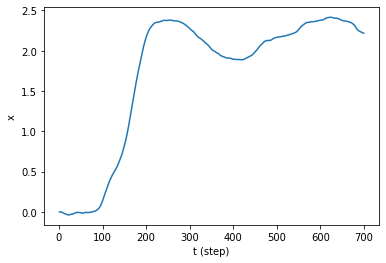

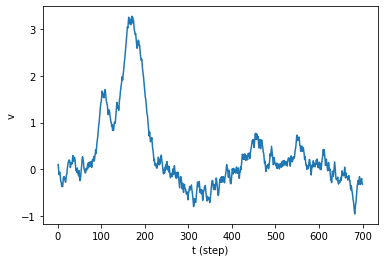

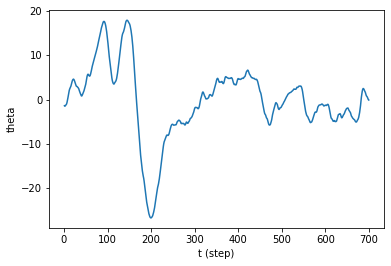

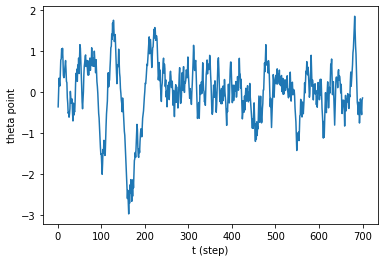

In [30]:
# There. we finished
# Lets see it in action
cartpole=CarPend()
done = False
cnt = 0
observation = cartpole.reset()

t=[]
x=[]
xp=[]
th=[]
thp=[]
while not done :
    cnt += 1
    t.append(cnt)

    action = agent.action(observation)
    observation, reward, done,_ = cartpole.step(action)
    x.append(observation[0])
    xp.append(observation[1])
    th.append(observation[2])
    thp.append(observation[3])



    # Lets see how long it lasts until failing


plt.figure()
plt.plot(t,x)
plt.xlabel('t (step)')
plt.ylabel('x')

plt.figure()
plt.plot(t,xp)
plt.xlabel('t (step)')
plt.ylabel('v')

plt.figure()
plt.plot(t,np.array(th)*180/np.pi)
plt.xlabel('t (step)')
plt.ylabel('theta')

plt.figure()
plt.plot(t,thp)
plt.xlabel('t (step)')
plt.ylabel('theta point')
#plt.figure()
#plt.plot(t,xpp)

plt.show()

Now you can see that entropy regularisation improve so much DDPG performances.

You don't need to remeber every performance improvement tricks we used in this notebook, but you should understand how DDPG and SAC works, and what are the differences between them, and between DQN and them.